SIFT+SVM

E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classification Report (Balanced):
              precision    recall  f1-score   support

 Agriculture       0.78      0.66      0.72       171
     Airport       0.58      0.58      0.58       158
       Beach       0.72      0.63      0.67       169
        City       0.69      0.75      0.71       166
      Desert       0.59      0.58      0.59       158
      Forest       0.77      0.87      0.82       143
   Grassland       0.57      0.72      0.64       167
     Highway       0.62      0.64      0.63       158
        Lake       0.44      0.38      0.41       154
    Mountain       0.78      0.82      0.80       162
     Parking       0.94      0.89      0.91       171
        Port       0.77      0.64      0.70       155
     Railway       0.67      0.71      0.69       164
 Residential       0.79      0.85      0.82       148
       River       0.46      0.45      0.46       156

    accuracy                           0

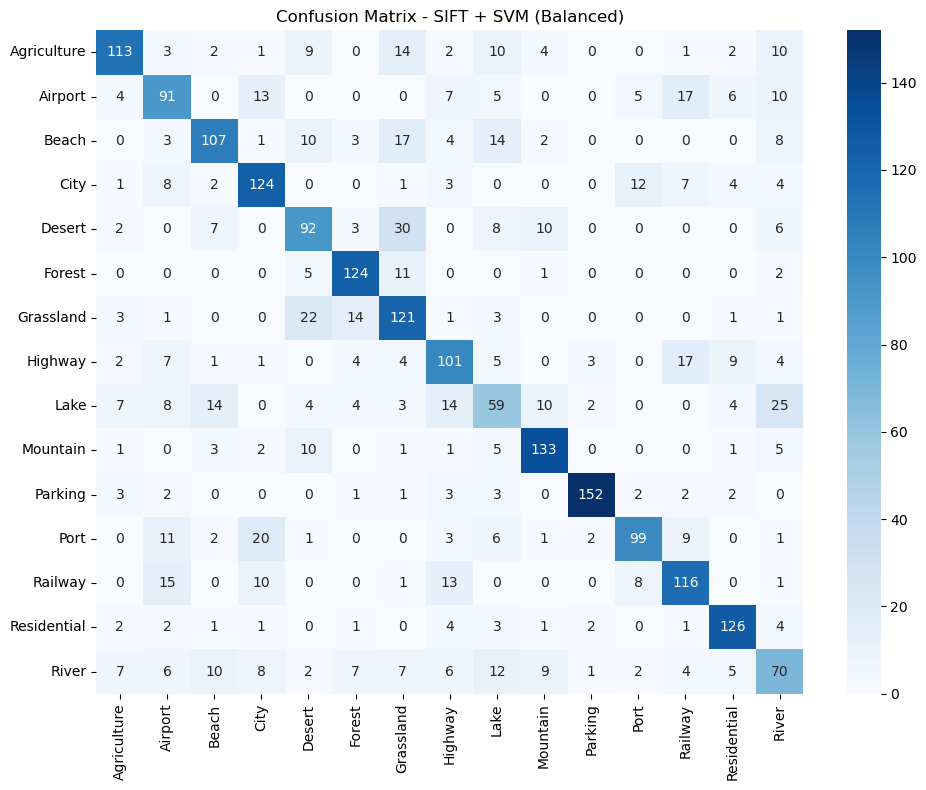

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classification Report (Imbalanced):
              precision    recall  f1-score   support

 Agriculture       0.62      0.82      0.71       171
     Airport       0.45      0.74      0.56       158
       Beach       0.55      0.69      0.61       169
        City       0.63      0.80      0.71       166
      Desert       0.45      0.75      0.56       158
      Forest       0.82      0.87      0.84       143
   Grassland       0.70      0.55      0.62       167
     Highway       0.62      0.71      0.66       158
        Lake       0.41      0.31      0.35       154
    Mountain       0.81      0.78      0.79       162
     Parking       0.91      0.84      0.88       171
        Port       0.80      0.52      0.63       155
     Railway       0.80      0.52      0.63       164
 Residential       0.94      0.67      0.78       148
       River       0.38      0.05      0.09       156

    accuracy                          

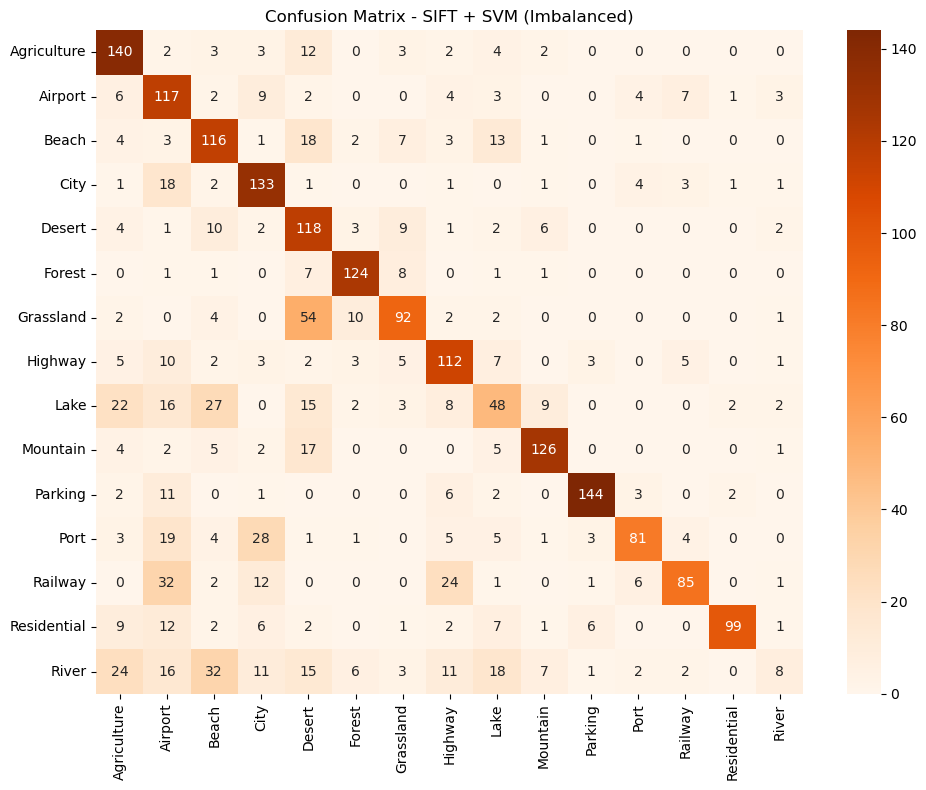

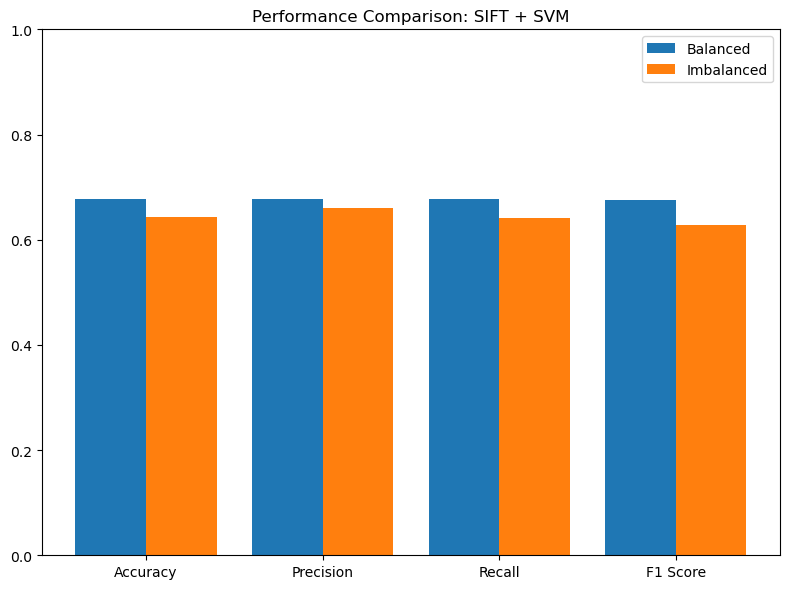

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import random
from collections import Counter

from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# ===================== Settings =====================
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 42
VOCAB_SIZE = 200
MAX_DESCRIPTORS_PER_IMAGE = 100
CV_FOLDS = 5
SVM_PARAM_GRID = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

# ===================== Paths =====================
DATASET_DIR = r"D:\\quark download\\9517 Week1 home work\\project\\Aerial_Landscapes"
INDEX_DIR = r"D:\\quark download\\9517 Week1 home work\\project\\preprocess"

# ===================== Load Dataset =====================
class_names = sorted(os.listdir(DATASET_DIR))
image_paths, labels = [], []
for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for file in sorted(os.listdir(class_dir)):
        if file.lower().endswith(".jpg"):
            image_paths.append(os.path.join(class_dir, file))
            labels.append(label_index)
labels = np.array(labels)

train_indices = np.load(os.path.join(INDEX_DIR, 'train_indices.npy'))
val_indices = np.load(os.path.join(INDEX_DIR, 'val_indices.npy'))

def load_images_by_indices(indices):
    X, y = [], []
    for i in indices:
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img / 255.0)
        y.append(labels[i])
    return np.array(X), np.array(y)

X_train_raw, y_train = load_images_by_indices(train_indices)
X_test_raw, y_test = load_images_by_indices(val_indices)

# ===================== SIFT & Codebook =====================
sift = cv2.SIFT_create()

def extract_sift_descriptors(img):
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return des

def build_codebook(images):
    descriptors = []
    for img in images:
        des = extract_sift_descriptors(img)
        if des is not None:
            if des.shape[0] > MAX_DESCRIPTORS_PER_IMAGE:
                des = des[np.random.choice(des.shape[0], MAX_DESCRIPTORS_PER_IMAGE, replace=False)]
            descriptors.append(des)
    all_des = np.vstack(descriptors)
    kmeans = MiniBatchKMeans(n_clusters=VOCAB_SIZE, random_state=RANDOM_STATE)
    kmeans.fit(all_des)
    return kmeans

kmeans = build_codebook(X_train_raw)

def compute_bow_histogram(des, kmeans):
    if des is None or des.shape[0] == 0:
        return np.zeros(VOCAB_SIZE)
    words = kmeans.predict(des)
    hist, _ = np.histogram(words, bins=np.arange(VOCAB_SIZE + 1))
    return hist.astype('float') / (hist.sum() + 1e-7)

def extract_sift_features(images):
    return np.array([compute_bow_histogram(extract_sift_descriptors(img), kmeans) for img in images])

X_train_feat = extract_sift_features(X_train_raw)
X_test_feat = extract_sift_features(X_test_raw)
scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_test_feat = scaler.transform(X_test_feat)

# ===================== Balanced Training =====================
svm = SVC(class_weight='balanced', random_state=RANDOM_STATE)
grid = GridSearchCV(svm, SVM_PARAM_GRID, cv=CV_FOLDS, verbose=1, n_jobs=-1)
grid.fit(X_train_feat, y_train)
y_pred = grid.predict(X_test_feat)

print("Classification Report (Balanced):")
print(classification_report(y_test, y_pred, target_names=class_names))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SIFT + SVM (Balanced)")
plt.tight_layout()
plt.show()

# ===================== Imbalanced + Augmented Dataset =====================
def augment_image(img):
    aug = []
    if random.random() < 0.5:
        aug.append(np.fliplr(img))
    if random.random() < 0.5:
        aug.append(np.flipud(img))
    if random.random() < 0.5:
        bright = np.clip(img + np.random.uniform(0.1, 0.3), 0, 1)
        aug.append(bright)
    if random.random() < 0.5:
        contrast = np.clip(img * np.random.uniform(0.7, 1.3), 0, 1)
        aug.append(contrast)
    return aug if aug else [img]

def create_imbalanced_dataset_with_aug(X, y, min_count=50):
    new_X, new_y = [], []
    original = np.sum(y == 0)
    for i, cls in enumerate(np.unique(y)):
        desired = int(round(original - i * ((original - min_count) / (len(np.unique(y)) - 1))))
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        selected = idx[:desired]
        for s in selected:
            new_X.append(X[s])
            new_y.append(y[s])
        if desired < 80:
            for s in selected:
                for aug in augment_image(X[s]):
                    new_X.append(aug)
                    new_y.append(y[s])
    return np.array(new_X), np.array(new_y)

X_imbal_raw, y_imbal = create_imbalanced_dataset_with_aug(X_train_raw, y_train)
X_imbal_feat = extract_sift_features(X_imbal_raw)
X_imbal_feat = scaler.transform(X_imbal_feat)

# ===================== Imbalanced Training =====================
svm_imb = SVC(class_weight='balanced', random_state=RANDOM_STATE)
grid_imb = GridSearchCV(svm_imb, SVM_PARAM_GRID, cv=CV_FOLDS, verbose=1, n_jobs=-1)
grid_imb.fit(X_imbal_feat, y_imbal)
y_pred_imb = grid_imb.predict(X_test_feat)

print("Classification Report (Imbalanced):")
print(classification_report(y_test, y_pred_imb, target_names=class_names))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_imb), annot=True, fmt='d', cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SIFT + SVM (Imbalanced)")
plt.tight_layout()
plt.show()

# ===================== Performance Comparison =====================
def get_scores(y_true, y_pred):
    return [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, average='macro'),
        recall_score(y_true, y_pred, average='macro'),
        f1_score(y_true, y_pred, average='macro')
    ]

scores_bal = get_scores(y_test, y_pred)
scores_imbal = get_scores(y_test, y_pred_imb)

x = np.arange(4)
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(8, 6))
plt.bar(x - 0.2, scores_bal, 0.4, label='Balanced')
plt.bar(x + 0.2, scores_imbal, 0.4, label='Imbalanced')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Performance Comparison: SIFT + SVM")
plt.legend()
plt.tight_layout()
plt.show()